In [51]:
import shutil                                                                                             
import pandas as pd
import numpy as np
import pretrainedmodels
import pretrainedmodels.utils as utils
import torch               
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable                            
from adversary.fgsm import Attack, where       
import adversary.cw as cw                      
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from settings import *

In [52]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

with open('data/imagenet_classes.txt', 'r') as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

In [53]:
load_img = utils.LoadImage()
tf_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
resnet18 = models.resnet18(pretrained=True)
fc_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_features, 20)
model = resnet18

In [54]:
checkpoint = torch.load(ADV_MINI_IMAGENET_CKPT)
model.load_state_dict(checkpoint['net'])
model = model.to(device)
model.eval()
print('model init')

model init


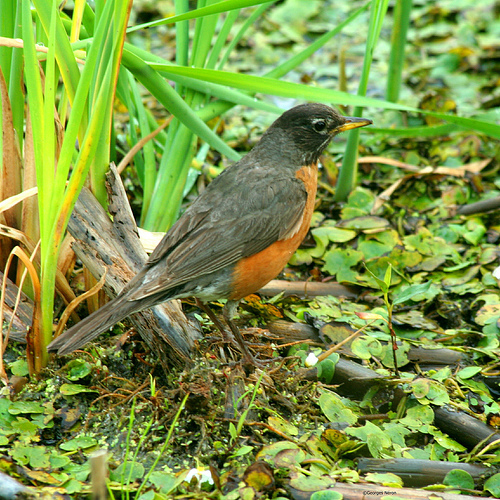

In [55]:
path_img = 'data/n01558993_10175.JPEG' #
input_img = load_img(path_img)
input_tensor = tf_img(input_img)  

input_tensor = input_tensor.unsqueeze(0) # 3x224x224 -> 1x3x224x224
input_tensor = input_tensor.to(device)
target = torch.LongTensor([0]).to(device)
input_img

In [56]:
# benign example
output_logits = model(input_tensor) 
class_id = torch.argmax(output_logits)

class_key = class_id_to_key[class_id]
classname = key_to_classname[class_key]
print('true class: ',key_to_classname['n01558993'])
print('predicted class: ',classname)
# input_img

true class:  robin, American robin, Turdus migratorius
predicted class:  robin, American robin, Turdus migratorius


In [57]:
EPSILON = 8 / 255
EPSILON_TRAIN = 1 / 255
criterion_none = nn.CrossEntropyLoss(reduction='none') 
bim_attack = Attack(model, F.cross_entropy)   
def FGSM(x, y_true, eps=8 / 255, alpha=1 / 255, iteration=10, bim_a=False):                                            
    x = Variable(x.to(device), requires_grad=False)                                                                    
    y_true = Variable(y_true.to(device), requires_grad=False)                                                          
                                                                                                                       
    if iteration == 1:                                                                                                 
        x_adv = bim_attack.fgsm(x, y_true, False, eps, x_val_min=0, x_val_max=1)                                      
    else:                                                                                                              
        if bim_a:                                                                                                      
            x_adv = bim_attack.i_fgsm_a(x, y_true, False, eps, alpha, iteration, x_val_min=0, x_val_max=1)            
        else:                                                                                                          
            x_adv = bim_attack.i_fgsm(x, y_true, False, eps, alpha, iteration, x_val_min=0, x_val_max=1)              
    return x_adv                                                                                                                                                                                                              

In [58]:
# benign undercover fgsm --> example1
benign_fgsm = FGSM(input_tensor, target, eps=EPSILON_TRAIN)                                
benign_fgsm_outputs = model(benign_fgsm)                                           
_, benign_fgsm_predicted = benign_fgsm_outputs.max(1)                            
temp1 = criterion_none(benign_fgsm_outputs, target).detach().cpu().numpy()
print('benign example criterion: ', temp1[0])

benign example criterion:  1.1444092e-05


In [59]:
# crafted adversarial example
x_adv = FGSM(input_tensor, target, eps=EPSILON, alpha=1 / 255, iteration=10, bim_a=True)
adv_outputs = model(x_adv)                                        
_, adv_predicted = adv_outputs.max(1)
adversarial_name = key_to_classname[class_id_to_key[adv_predicted]]
print('adv class: ', adversarial_name)

adv class:  carousel, carrousel, merry-go-round, roundabout, whirligig


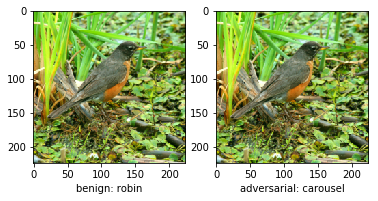

In [60]:
# show img
original_image = transforms.Resize((224,224))(input_img)
adversarial_image = transforms.ToPILImage()(x_adv[0].detach().cpu())
plt.figure()
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.xlabel('benign: '+classname[0:5])
plt.subplot(1,2,2)
plt.imshow(original_image)
plt.xlabel('adversarial: '+adversarial_name[0:8])
plt.show()

In [61]:
# adv undercover fgsm
adv_fgsm = FGSM(x_adv, adv_predicted, eps=EPSILON_TRAIN)  #                           
adv_fgsm_outputs = model(adv_fgsm)                                                
_, adv_fgsm_predicted = adv_fgsm_outputs.max(1)                                 
temp2 = criterion_none(adv_fgsm_outputs, adv_predicted).detach().cpu().numpy()
print('adversarial example criterion: ', temp2[0])

adversarial example criterion:  2.758562
